In [1]:
# !pip install pennylane koreanize_matplotlib scikit-learn -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
FEAT_IDX  = [2, 3]   # 사용할 feature: [0,1] / [2,3] / [0,1,2,3]
N_REPEATS = 1        # IQP 반복 횟수: 1 / 2
# ===== 수정 끝 =====
# ============================================================

N_QUBITS   = len(FEAT_IDX)
feat_names = [load_iris().feature_names[i] for i in FEAT_IDX]

print("=" * 60)
print("lab9: Quantum Kernel SVM  (Fidelity 기반)")
print("=" * 60)
print(f"  feature: {feat_names}")
print(f"  N_QUBITS={N_QUBITS}  |  N_REPEATS={N_REPEATS}")

# ===========================================================
#  1. 데이터 준비
# ===========================================================
iris     = load_iris()
X_raw    = iris.data[:, FEAT_IDX]
y        = iris.target

X = MinMaxScaler((0, std_np.pi)).fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_train = np.array(X_train)
X_test  = np.array(X_test)

print(f"\n  train: {len(X_train)}개, test: {len(X_test)}개")
print(f"  클래스: {list(iris.target_names)}")

# ===========================================================
#  2. Fidelity 양자 커널
# ===========================================================
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.IQPEmbedding(x1, wires=range(N_QUBITS), n_repeats=N_REPEATS)
    qml.adjoint(qml.IQPEmbedding)(x2, wires=range(N_QUBITS),
                                   n_repeats=N_REPEATS)
    return qml.probs(wires=range(N_QUBITS))

def kernel(x1, x2):
    return float(kernel_circuit(x1, x2)[0])   # |<x1|x2>|² = fidelity

print("\n  [Fidelity 커널 원리]")
print("  IQP(x1) * adjoint(IQP(x2)) -> probs[0] = |<x1|x2>|^2")
print("  x1 = x2 이면 fidelity = 1.0  (완전히 같은 상태)")
print("  x1 != x2 이면 fidelity < 1.0 (다른 상태)")

# 커널 행렬 계산
print("\n  커널 행렬 계산 중...")
K_train = qml.kernels.kernel_matrix(X_train, X_train, kernel)
K_test  = qml.kernels.kernel_matrix(X_test,  X_train, kernel)

print(f"  K_train 형상: {K_train.shape}")
print(f"  K_train 범위: {K_train.min():.4f} ~ {K_train.max():.4f}")
print(f"  대각선(자기 유사도) 평균: {std_np.diag(K_train).mean():.4f}  (이론: 1.0)")

lab9: Quantum Kernel SVM  (Fidelity 기반)
  feature: ['petal length (cm)', 'petal width (cm)']
  N_QUBITS=2  |  N_REPEATS=1

  train: 105개, test: 45개
  클래스: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

  [Fidelity 커널 원리]
  IQP(x1) * adjoint(IQP(x2)) -> probs[0] = |<x1|x2>|^2
  x1 = x2 이면 fidelity = 1.0  (완전히 같은 상태)
  x1 != x2 이면 fidelity < 1.0 (다른 상태)

  커널 행렬 계산 중...
  K_train 형상: (105, 105)
  K_train 범위: 0.0024 ~ 1.0000
  대각선(자기 유사도) 평균: 1.0000  (이론: 1.0)


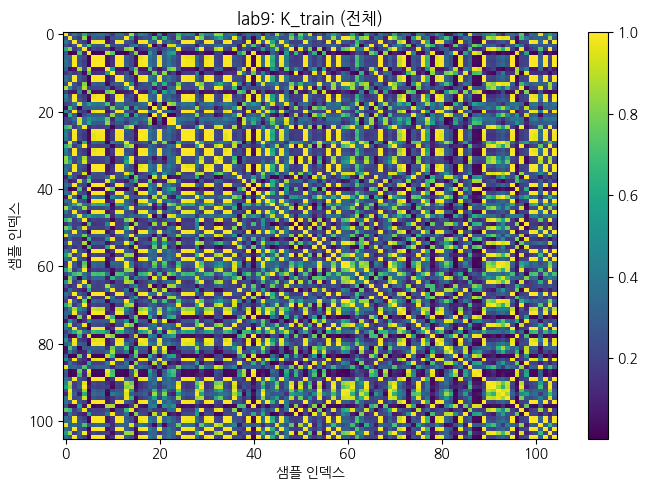

In [2]:
fig, ax = plt.subplots(figsize=(7, 5))

im = ax.imshow(K_train, cmap='viridis', aspect='auto')
cbar = fig.colorbar(im, ax=ax)

ax.set_title("lab9: K_train (전체)")
ax.set_xlabel("샘플 인덱스")
ax.set_ylabel("샘플 인덱스")

plt.tight_layout()
fig.savefig("./fig/lab9a.png", dpi=300, bbox_inches="tight")
plt.show()

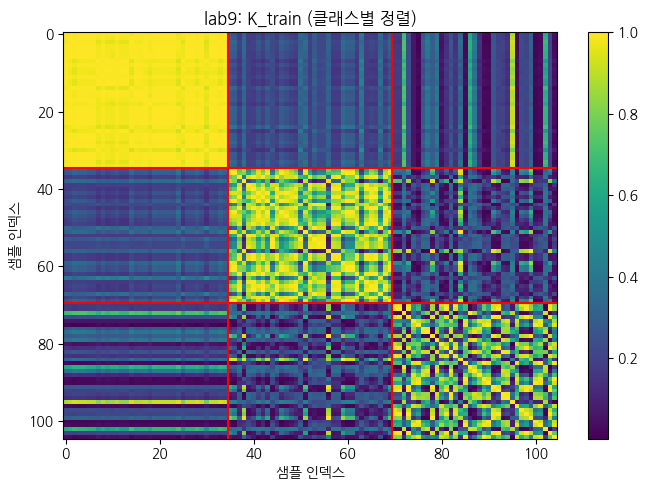

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))

sort_idx = std_np.argsort(y_train)
K_sorted = K_train[std_np.ix_(sort_idx, sort_idx)]

im = ax.imshow(K_sorted, cmap='viridis', aspect='auto')
cbar = fig.colorbar(im, ax=ax)

ax.set_title("lab9: K_train (클래스별 정렬)")
ax.set_xlabel("샘플 인덱스")
ax.set_ylabel("샘플 인덱스")

# 클래스 경계선 계산
class_counts = [std_np.sum(y_train[sort_idx] == c) for c in std_np.unique(y_train)]
pos = 0
for count in class_counts[:-1]:
    pos += count
    ax.axhline(pos - 0.5, color='red', lw=1.5)
    ax.axvline(pos - 0.5, color='red', lw=1.5)

plt.tight_layout()
fig.savefig("./fig/lab9b.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
# ===========================================================
#  3. QSVC vs RBF SVC 학습
# ===========================================================
print("\n" + "=" * 60)
print("lab9: QSVC vs RBF SVC 학습")
print("=" * 60)

# QSVC
qsvc = SVC(kernel="precomputed", decision_function_shape="ovr")
qsvc.fit(K_train, y_train)
qsvc_tr = round(qsvc.score(K_train, y_train), 4)
qsvc_te = round(qsvc.score(K_test,  y_test),  4)

# RBF SVC
rbf = SVC(kernel="rbf", gamma="scale", decision_function_shape="ovr")
rbf.fit(X_train, y_train)
rbf_tr = round(rbf.score(X_train, y_train), 4)
rbf_te = round(rbf.score(X_test,  y_test),  4)

print(f"\n  {'':>10s}  {'train Acc':>10s}  {'test Acc':>10s}")
print("  " + "-" * 35)
print(f"  {'QSVC':>10s}  {qsvc_tr:>10.4f}  {qsvc_te:>10.4f}")
print(f"  {'RBF SVC':>10s}  {rbf_tr:>10.4f}  {rbf_te:>10.4f}")


lab9: QSVC vs RBF SVC 학습

               train Acc    test Acc
  -----------------------------------
        QSVC      0.9619      0.9111
     RBF SVC      0.9810      0.9111


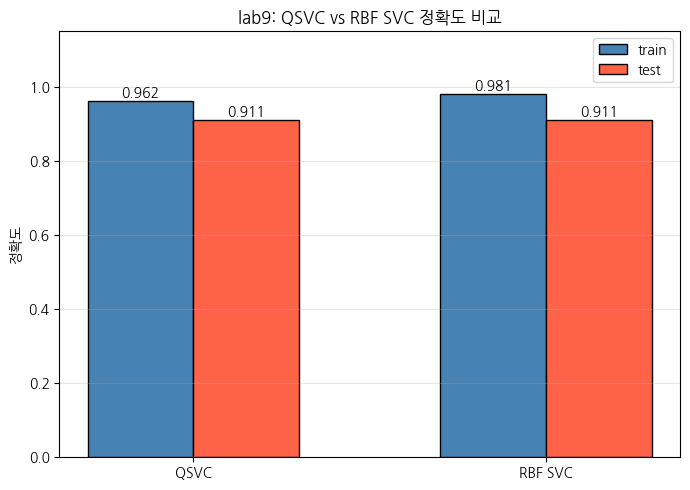

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

labels  = ['QSVC', 'RBF SVC']
tr_accs = [qsvc_tr, rbf_tr]
te_accs = [qsvc_te, rbf_te]

x_pos = std_np.arange(2)
width = 0.3

ax.bar(x_pos - width/2, tr_accs, width,
       color='steelblue', edgecolor='black', label='train')

ax.bar(x_pos + width/2, te_accs, width,
       color='tomato', edgecolor='black', label='test')

for i, (tr, te) in enumerate(zip(tr_accs, te_accs)):
    ax.text(i - width/2, tr + 0.01, f'{tr:.3f}', ha='center')
    ax.text(i + width/2, te + 0.01, f'{te:.3f}', ha='center')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.15)
ax.set_ylabel("정확도")
ax.set_title("lab9: QSVC vs RBF SVC 정확도 비교")

ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab9c.png", dpi=300, bbox_inches="tight")
plt.show()

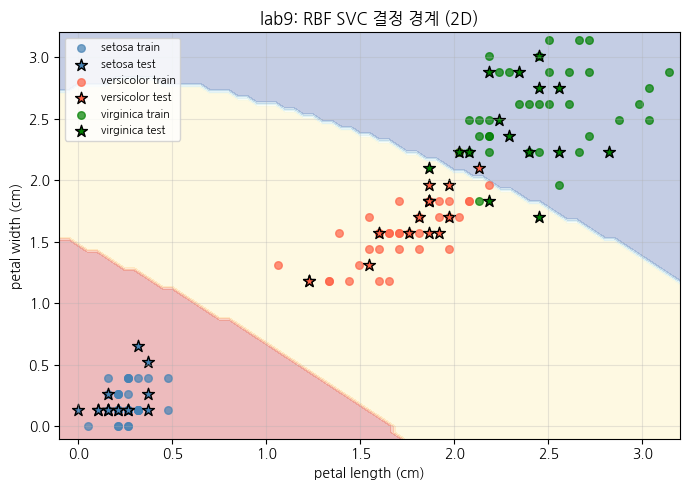

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))

h = 0.05
x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

xx, yy = std_np.meshgrid(
    std_np.arange(x0_min, x0_max, h),
    std_np.arange(x1_min, x1_max, h)
)

Z = rbf.predict(std_np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

colors = ['steelblue', 'tomato', 'green']
for c, (name, color) in enumerate(zip(iris.target_names, colors)):
    mask_tr = y_train == c
    mask_te = y_test  == c

    ax.scatter(X_train[mask_tr, 0], X_train[mask_tr, 1],
               c=color, s=30, alpha=0.7, label=f'{name} train')

    ax.scatter(X_test[mask_te, 0],  X_test[mask_te, 1],
               c=color, s=80, marker='*', edgecolors='black',
               label=f'{name} test')

ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])
ax.set_title("lab9: RBF SVC 결정 경계 (2D)")

ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab9d.png", dpi=300, bbox_inches="tight")
plt.show()